# Bungee Dunk

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [ ]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

Suppose you want to set the world record for the highest "bungee dunk", which is a stunt in which a bungee jumper dunks a cookie in a cup of tea at the lowest point of a jump. An example is shown in this video: <http://modsimpy.com/dunk>.

Since the record is 70 m, let's design a jump for 80 m. We'll start with the following modeling assumptions:

-   Initially the bungee cord hangs from a crane with the attachment
    point 80 m above a cup of tea.

-   Until the cord is fully extended, it applies no force to the jumper.  It turns out this might not be a good assumption; we'll revisit it in the next case study.

-   After the cord is fully extended, it obeys Hooke's Law; that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length. See <http://modsimpy.com/hooke>.

-   The mass of the jumper is 75 kg.

-   The jumper is subject to drag force so that their terminal velocity is 60 m/s.

Our objective is to choose the length of the cord, `L`, and its spring
constant, `k`, so that the jumper falls all the way to the tea cup, but no farther!

First, we'll create a `params` object to contain the quantities we'll need:

1. Let's assume that the jumper's mass is 75 kg.

2. With a terminal velocity of 60 m/s.

3. The length of the bungee cord is `L = 40 m`.

4. The spring constant of the cord is `k = 20 N / m` when the cord is stretched, and 0 when it's compressed.


In [ ]:
params = dict(y_attach = 80,   # m,
                 v_init = 0,     # m / s,
                 g = 9.8,        # m/s**2,
                 mass = 75,      # kg,
                 area = 1,       # m**2,
                 rho = 1.2,      # kg/m**3,
                 v_term = 60,    # m / s,
                 L = 25,         # m,
                 k = 40)         # N / m

Now here's a version of `make_system` that takes a `params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [ ]:
def make_system(params):
    """Makes a System object for the given params.
    
    params: Params object
    
    returns: System object
    """
    
    y_attach, v_init, g, mass, area, rho, v_term, L, k = params.values()
    
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = pd.Series(dict(y=y_attach, v=v_init))
    t_end = 20

    return dict(y_attach=y_attach, v_init=v_init, g=g,
                mass=mass, area=area, rho=rho,
                v_term=v_term, L=L, k=k,
                C_d=C_d, init=init, t_end=t_end)

Let's make a `system`

In [ ]:
system = make_system(params)

`spring_force` computes the force of the cord on the jumper.

If the spring is not extended, the spring force is set to 0:

In [ ]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system|
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    y_attach, L, k = system['y_attach'], system['L'], system['k']
    
    distance_fallen = y_attach - y
    if distance_fallen <= L:
        return 0
    
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring

The spring force is 0 until the cord is fully extended.  When it is extended 1 m, the spring force is 40 N. 

In [ ]:
spring_force(55, system)

0

In [ ]:
spring_force(54, system)

40

`drag_force` computes drag as a function of velocity:

In [ ]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object

    returns: drag force
    """
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

Here's the drag force at 60 meters per second.

In [ ]:
v = -60
f_drag = drag_force(v, system)
f_drag

735.0

Acceleration due to drag at 60 m/s is approximately g, which confirms that 60 m/s is terminal velocity.

In [ ]:
a_drag = f_drag / system['mass']
a_drag

9.8

Now here's the slope function:

In [ ]:
def slope_func(t, state, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    mass, g = system['mass'], system['g']
    
    a_drag = drag_force(v, system) / mass
    a_spring = spring_force(y, system) / mass
    
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt

As always, let's test the slope function with the initial params.

In [ ]:
slope_func(0, system['init'], system)

(0, -9.8)

And then run the simulation.

In [ ]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

Here's the plot of position as a function of time.

In [ ]:
def plot_position(results):
    results.y.plot(xlabel='Time (s)',
             ylabel='Position (m)')

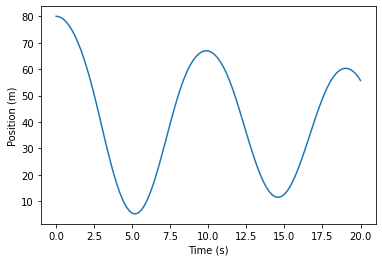

In [ ]:
plot_position(results)

After reaching the lowest point, the jumper springs back almost to almost 70 m and oscillates several times.  That looks like more oscillation that we expect from an actual jump, which suggests that there is some dissipation of energy in the real world that is not captured in our model.  To improve the model, that might be a good thing to investigate.

But since we are primarily interested in the initial descent, the model might be good enough for now.

We can use `min` to find the lowest point:

In [ ]:
min(results.y)

5.179494952188653

At the lowest point, the jumper is still too high, so we'll need to increase `L` or decrease `k`.

Here's velocity as a function of time:

In [ ]:
def plot_velocity(results):
    results.v.plot(color='C1', label='v',
                   xlabel='Time (s)',
                   ylabel='Velocity (m/s)',
                  legend=True)

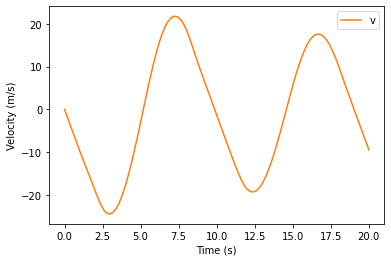

In [ ]:
plot_velocity(results)

Although we compute acceleration inside the slope function, we don't get acceleration as a result from `run_solve_ivp`.

We can approximate it by computing the numerical derivative of the velocity.  We'll use a NumPy method called `gradient`, and enter the velocity and time sequences as our arguments.  `gradient` produces an array of acceleration values, so to plot it, we simply match that array up with the time steps in `results.index` to create a `pd.Series`.

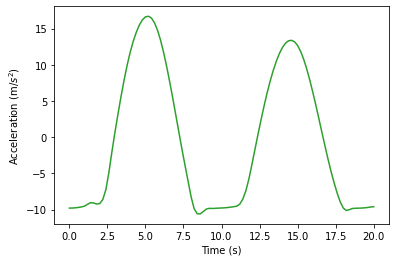

In [ ]:
import numpy as np

a = np.gradient(results.v, results.index)
a_series = pd.Series(data=a,index=results.index)
a_series.plot(color='C2',xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)');

And we can compute the maximum acceleration the jumper experiences:

In [ ]:
max_acceleration = max(a)
max_acceleration

16.70936120347338

Relative to the acceleration of gravity, the jumper "pulls" about "1.7 g's": that is, he experiences an acceleration that is 1.7 times larger than the acceleration of gravity *g*:

In [ ]:
max_acceleration / system['g']

1.7050368574972836

## Solving for length

Assuming that `k` is fixed, let's find the length `L` that makes the minimum altitude of the jumper exactly 0.

The metric we are interested in is the lowest point of the first oscillation.  For both efficiency and accuracy, it is better to stop the simulation when we reach this point, rather than run past it and then compute the minimum.

Here's an event function that stops the simulation when velocity is 0.

In [ ]:
def event_func(t, state, system):
    """Return velocity.
    """
    y, v = state
    return v

As usual, we should test it with the initial conditions.

In [ ]:
event_func(0, system['init'], system)

0

If we call `run_solve_ivp` with this event function, we'll see that the simulation stops immediately because the initial velocity is 0.

We could work around that by starting with a very small, non-zero initial velocity.
But we can also avoid it by setting the `direction` attribute of the `event_func`:

In [ ]:
event_func.direction = 1

The value 1 (or any positive value) indicates that the event should only occur if the result from `event_func` is increasing.
A negative value would indicate that the results should be decreasing.  Since in our simulation the velocity is initially decreasing (since *down* is defined as neative), it will not stop the simulation immediately.

Now we can test it and confirm that it stops at the bottom of the jump.

In [ ]:
results, details = run_solve_ivp(system, slope_func, 
                                 events=event_func)
details.message

'A termination event occurred.'

Here are the results.

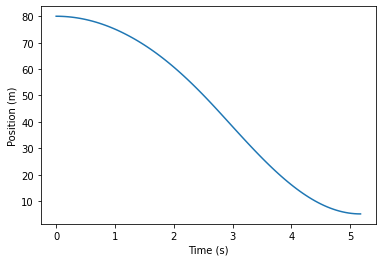

In [ ]:
plot_position(results)

And here's the height of the jumper at the lowest point.

In [ ]:
min(results.y)

5.174768018367087

### Exercise 1

Write an error function that takes `L` and `system` as arguments, simulates a bungee jump, and returns the lowest point.

Test the error function with a guess of 25 m and confirm that the return value is about 5 meters.

Use `root_scalar` with your error function to find the value of `L` that yields a perfect bungee dunk.

Run a simulation with the result from `root_scalar` and confirm that it works.

In [ ]:
# Write and test the error function

def error_func(L, system):
    system['L'] = L
    results, details = run_solve_ivp(system,slope_func,events = event_func)
    y_final = results.iloc[-1].y
    print(L,y_final)
    return y_final

system1 = make_system(params)
error_func(25,system1)

25 5.174768018367087


5.174768018367087

In [ ]:
# Use root_scalar to find the ideal length L

res1 = root_scalar(error_func, system1, bracket=[25,35])
res1.root

25 5.174768018367087
25.0 5.174768018367087
35.0 -8.127562239582353
28.89012144340249 -0.1827682893041465
28.757412899667933 -0.03607206622973043
28.725006251739707 -0.0008905337538318986
28.72357000142612 0.000662937898270554


28.72357000142612

In [ ]:
# Confirm the results from the previous step

params2 = params.copy()
params2.update(dict(L = 28.72357))
system2 = make_system(params2)
results2, details = run_solve_ivp(system2,slope_func,events=event_func)
results2.iloc[-1].y

0.0006629394404836404